In [16]:
import glob
import logging
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sqlalchemy import create_engine

from ppcx_pymc_func import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
)
from src.clustering import preproc_features
from src.config import ConfigManager
from src.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from src.logger import setup_logger
from src.preprocessing import apply_dic_filters, spatial_subsample
from src.roi import PolygonROISelector

%matplotlib widget

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
logger = setup_logger(logging.INFO, name="ppcx", force=True)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [ ]:
camera_name = "PPCX_Tele"
reference_start_date = "2024-08-23"
reference_end_date = "2024-08-28"

SUBSAMPLE_FACTOR = 1  # Take every n point
SUBSAMPLE_METHOD = "regular"  # or 'random', 'stratified'
PRIOR_STRENGTH = 0.4  # Between 0 and 1

output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

In [3]:
# Fetch DIC data
out = get_multi_dic_data(dic_ids, stack_results=False)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
df = pd.concat(
    [
        apply_dic_filters(
            df,
            filter_outliers=config.get("dic.filter_outliers"),
            tails_percentile=config.get("dic.tails_percentile"),
            min_velocity=config.get("dic.min_velocity"),
            apply_2d_median=config.get("dic.apply_2d_median"),
            median_window_size=config.get("dic.median_window_size"),
            median_threshold_factor=config.get("dic.median_threshold_factor"),
        )
        for df in out.values()
    ],
    ignore_index=True,
)

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logger.info(f"Data shape after filtering: {df.shape}")


# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===
variables_names = config.get("clustering.variables_names")
logger.info(f"Using features: {variables_names}")
df_features = preproc_features(df)
X = df_features[variables_names].values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
n_features = X_scaled.shape[1]
ndata = X_scaled.shape[0]
logger.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-10 16:45:43 | [INFO    ] Found stack of 6 DIC dataframes. Run filtering...
2025-09-10 16:45:45 | [INFO    ] Data shape after filtering: (11233, 5)
2025-09-10 16:45:45 | [INFO    ] Data shape after subsampling: (11233, 5)
2025-09-10 16:45:45 | [INFO    ] Using features: ['V']
2025-09-10 16:45:45 | [INFO    ] Feature matrix shape: (11233, 1)


Filtered 20994 points to 11233 points inside polygon
Subsampled from 11233 to 11233 points (100.0%)


2025-09-10 16:45:46 | [INFO    ] Found 4 sector polygons for priors
2025-09-10 16:45:46 | [INFO    ] Sector 0: 1238 points with strong prior
2025-09-10 16:45:46 | [INFO    ] Sector 1: 2141 points with strong prior
2025-09-10 16:45:46 | [INFO    ] Sector 2: 2245 points with strong prior
2025-09-10 16:45:46 | [INFO    ] Sector 3: 4976 points with strong prior


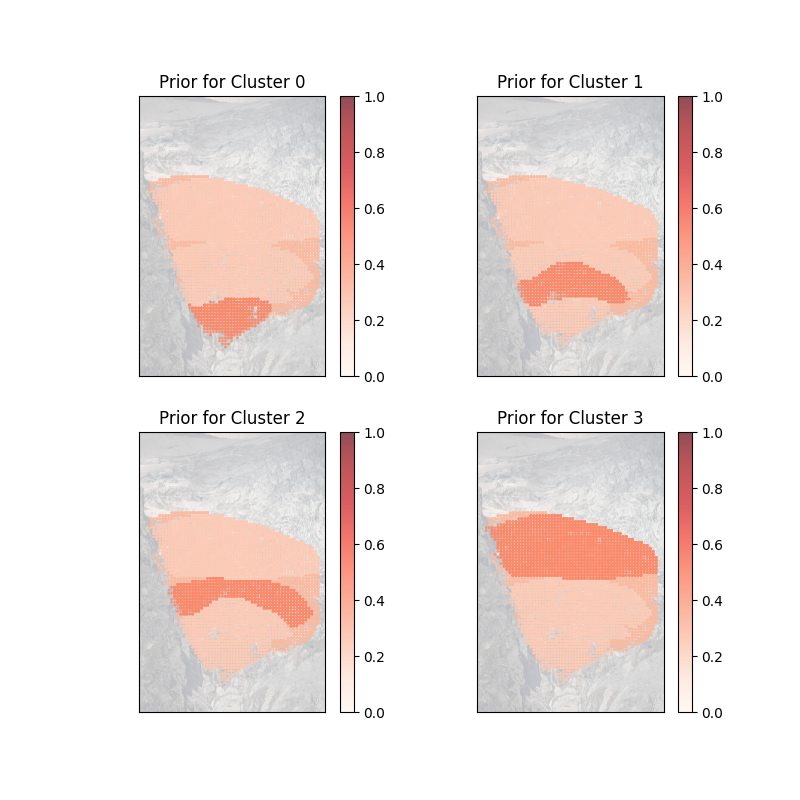

In [4]:
# === SPATIAL PRIOR SETUP ===

# Load sector polygons for priors
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sector_sectors = [PolygonROISelector.from_file(f) for f in sector_files]
k = len(sector_sectors)  # number of clusters = number of sectors
logger.info(f"Found {k} sector polygons for priors")

# Assign priors
prior_probs = assign_spatial_priors(df, sector_sectors, prior_strength=PRIOR_STRENGTH)

# Visualize priors
nrows = int(np.ceil(np.sqrt(k)))
ncols = int(np.ceil(k / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = [axes] if k == 1 else axes.flatten()
for cluster in range(k):
    axes[cluster].imshow(img, alpha=0.3)
    scatter = axes[cluster].scatter(
        df["x"],
        df["y"],
        c=prior_probs[:, cluster],
        cmap="Reds",
        s=1,
        alpha=0.7,
        vmin=0,
        vmax=1,
    )
    axes[cluster].set_title(f"Prior for Cluster {cluster}")
    axes[cluster].xaxis.set_ticks([])
    axes[cluster].yaxis.set_ticks([])
    plt.colorbar(scatter, ax=axes[cluster])

plt.show()

In [5]:
# Marginalized mixture model (no discrete z) --> faster sampling, but no direct cluster assignments
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model:
    # cluster parameters (continuous only)
    μ = pm.Normal("μ", mu=0, sigma=3, dims=("cluster", "feature"))
    σ = pm.HalfNormal("σ", sigma=1.5, dims=("cluster", "feature"))

    # register data as pm.Data so you can reuse the model and call pm.set_data
    X_shared = pm.Data("X_shared", X_scaled)  # shape (ndata, n_features)
    priors_shared = pm.Data("priors_shared", prior_probs)  # shape (ndata, k)

    # compute per-observation, per-component log-likelihood (diagonal cov assumed)
    # shapes: X_shared (ndata, 1, feature), μ (1, k, feature) -> broadcast to (ndata, k, feature)
    diff = X_shared[:, None, :] - μ[None, :, :]  # (ndata, k, feature)
    inv_sigma = 1.0 / σ[None, :, :]  # (1, k, feature)
    sq = (diff * inv_sigma) ** 2

    # Normal logpdf per feature: -0.5 * ((x-mu)/σ)^2 - log(σ) - 0.5*log(2π)
    log_comp_feat = (
        -0.5 * sq - pm.math.log(σ)[None, :, :] - 0.5 * pm.math.log(2 * np.pi)
    )
    log_comp = log_comp_feat.sum(axis=2)  # (ndata, k)

    # add log spatial priors and marginalize via logsumexp
    log_priors = pm.math.log(priors_shared + 1e-12)  # (ndata, k)
    log_mixture_per_obs = pm.math.logsumexp(log_priors + log_comp, axis=1)  # (ndata,)

    # add total log-likelihood as a potential (no discrete z variable)
    pm.Potential("mixture_likelihood", log_mixture_per_obs.sum())

logger.info("Marginalized mixture model created (no discrete z).")


2025-09-10 16:45:52 | [INFO    ] Marginalized mixture model created (no discrete z).


In [ ]:
LOAD_EXISTING = True  # Set to False to run sampling again

# Sampling (now NUTS can be used for μ, σ)
if LOAD_EXISTING is False:
    with model:
        logger.info("Starting MCMC sampling...")
        idata = pm.sample(
            target_accept=0.9,
            draws=1000,
            tune=1000,
            chains=4,
            cores=4,
            random_seed=RANDOM_SEED,
        )
    logger.info("Sampling completed!")

    # save the posterior InferenceData object and the scaler
    fpath = output_dir / f"{base_name}_posterior.idata.nc"
    az.to_netcdf(idata, fpath)
    joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
else:
    logger.info("Loading existing posterior InferenceData object...")
    idata = az.from_netcdf(output_dir / f"{base_name}_pooled_posterior.idata.nc")

In [8]:
# Check R-hat (should be < 1.01)
print("R-hat values (should be < 1.01):")
rhat = az.rhat(idata)
print("\tmu values:", rhat.μ.values.flatten())
print("\tsigma values:", rhat.σ.values.flatten())

# Check effective sample size (should be > 100)
print("Effective sample size (should be > 100):")
ess = az.ess(idata)
print("\tmu values:", ess.μ.values.flatten())
print("\tsigma values:", ess.σ.values.flatten())

R-hat values (should be < 1.01):
	mu values: [1.00064362 1.00102882 1.00354642 1.00014014]
	sigma values: [1.00226693 1.00153802 1.00059207 1.00078411]
Effective sample size (should be > 100):
	mu values: [2885.44986879 2300.50935935 2158.10843413 3160.78510714]
	sigma values: [3113.85336587 2481.13776798 3037.72983395 3300.875908  ]


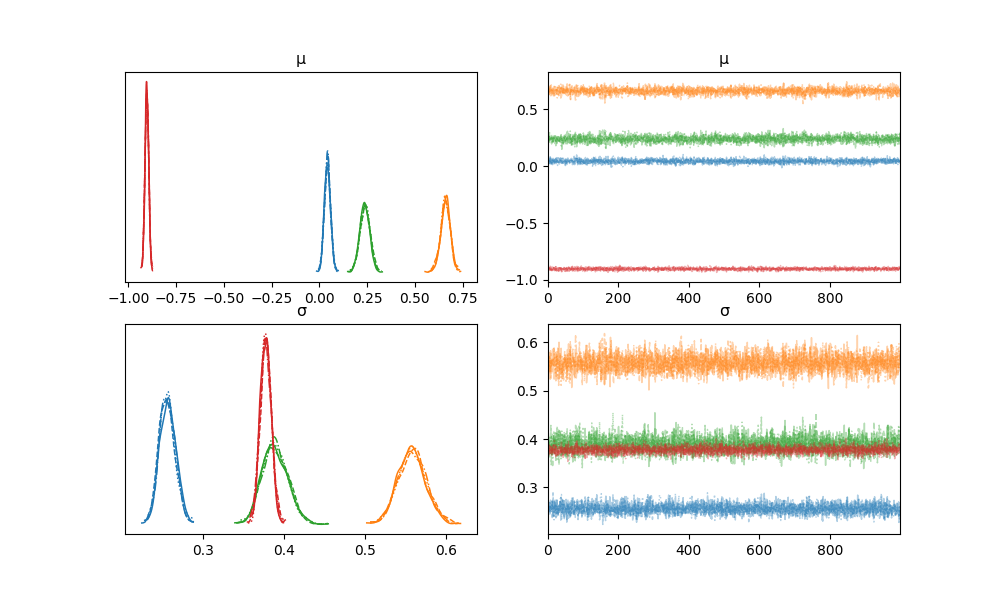

In [9]:
# Plot trace plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_trace(idata, var_names=["μ", "σ"], axes=axes, compact=True)
fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)

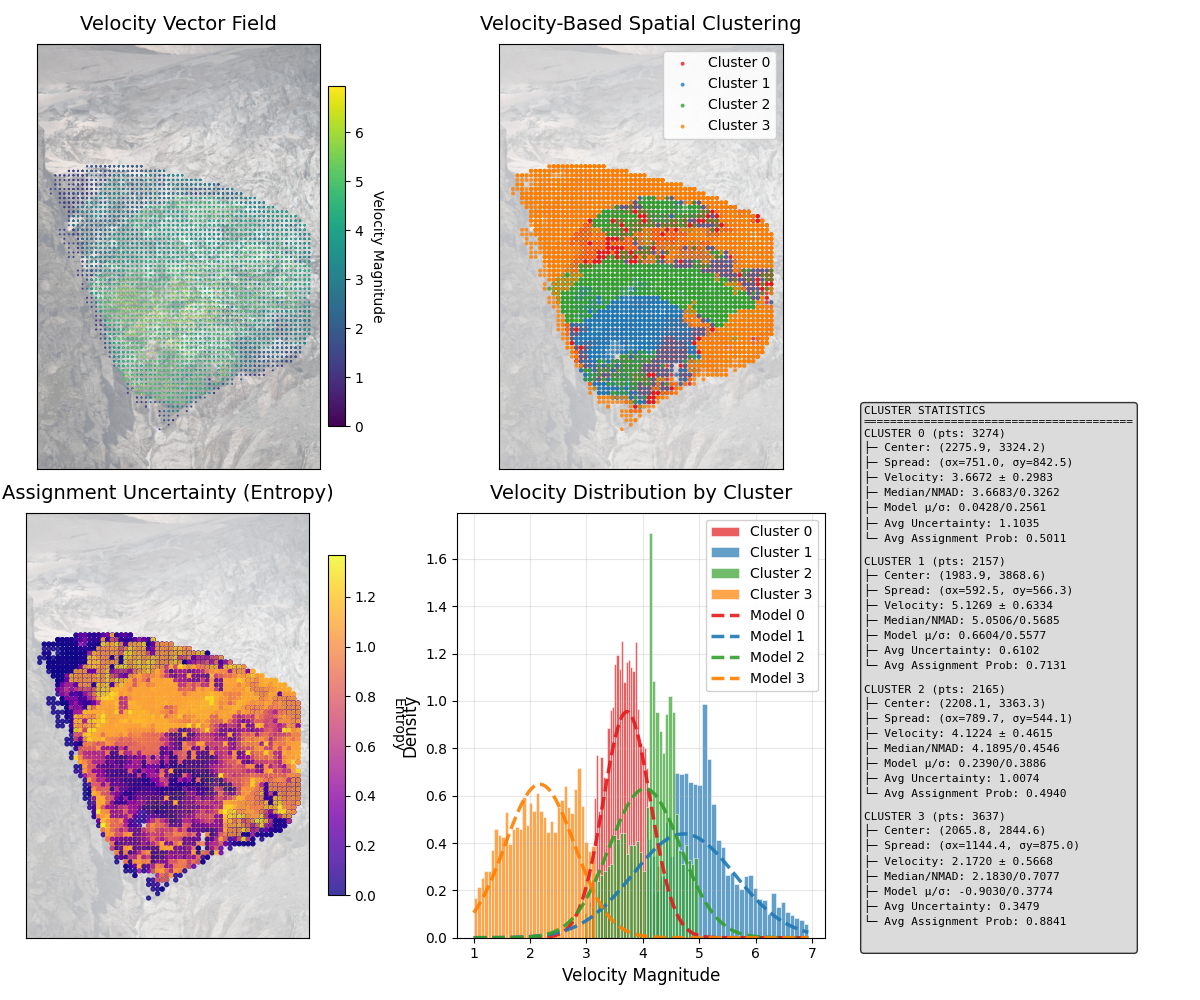

In [17]:
## === POSTERIOR ANALYSIS: ASSIGN POINTS TO CLUSTERS ===

# compute cluster assignments (subsample 200 posterior draws to save time)
posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
    idata, X_scaled, prior_probs, n_posterior_samples=200
)
fig, uncertainty = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")